In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install gprofiler-official
!pip install gseapy
!pip install gseapy networkx matplotlib

In [7]:
import pandas as pd
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from collections import defaultdict


In [8]:
filename = '/content/drive/MyDrive/skeletal_muscle.csv'
data = pd.read_csv(filename)
skeletal_muscle = pd.DataFrame(data)

In [71]:
skeletal_muscle.head()

,Unnamed: 0,names,scores,pvals,pvals_adj
0,0,APOD,31.004278,4.720000e-211,9.440000e-208
1,1,DCN,30.380283,1.000000e-202,2.000000e-199
2,2,GSN,29.149391,8.500000e-187,1.700000e-183
3,3,CFD,26.491886,1.200000e-154,2.400000e-151
4,4,MGP,25.059530,1.370000e-138,2.750000e-135


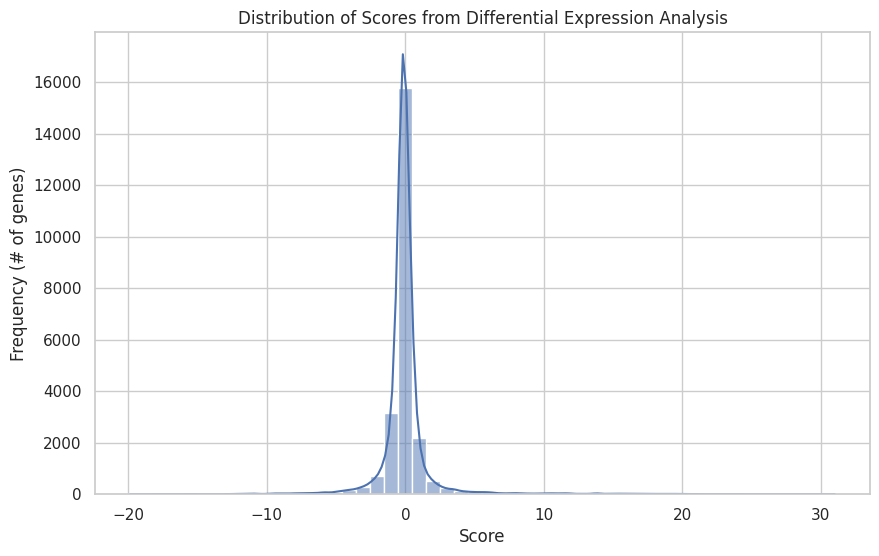

In [9]:
# view distribution of scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(skeletal_muscle['scores'], bins=50, kde=True)
plt.title('Distribution of Scores from Differential Expression Analysis')
plt.xlabel('Score')
plt.ylabel('Frequency (# of genes)')
plt.show()

# Gene Ontology Analysis


In [10]:
# Calculate mean and standard deviation of the scores
mean_score = skeletal_muscle['scores'].mean()
std_score = skeletal_muscle['scores'].std()

# Set the threshold as mean + 1.5 standard deviations
threshold = mean_score + 1.5 * std_score


# Filter for genes with scores greater than the threshold and p-value < 0.05
significant_genes = skeletal_muscle[
    (skeletal_muscle['scores'] > threshold) &
    (skeletal_muscle['pvals_adj'] < 0.05)
]

# Extract the list of gene names for these significant genes

gene_list = significant_genes['names'].tolist()

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Perform GO analysis using the significant gene list
go_results = gp.profile(organism='hsapiens', query=gene_list)

# Display the first few results
print(go_results.head())

  source      native                      name       p_value  significant  \
0  GO:CC  GO:0005576      extracellular region  1.854147e-35         True   
1  GO:CC  GO:0071944            cell periphery  8.323274e-33         True   
2  GO:CC  GO:0005615       extracellular space  3.498585e-32         True   
3  GO:BP  GO:0001568  blood vessel development  8.043639e-31         True   
4  GO:BP  GO:0001944   vasculature development  1.181784e-30         True   

                                         description  term_size  query_size  \
0  "The space external to the outermost structure...       4213         300   
1  "The broad region around and including the pla...       6228         300   
2  "That part of a multicellular organism outside...       3303         300   
3  "The process whose specific outcome is the pro...        721         294   
4  "The process whose specific outcome is the pro...        752         294   

   intersection_size  effective_domain_size  precision    reca

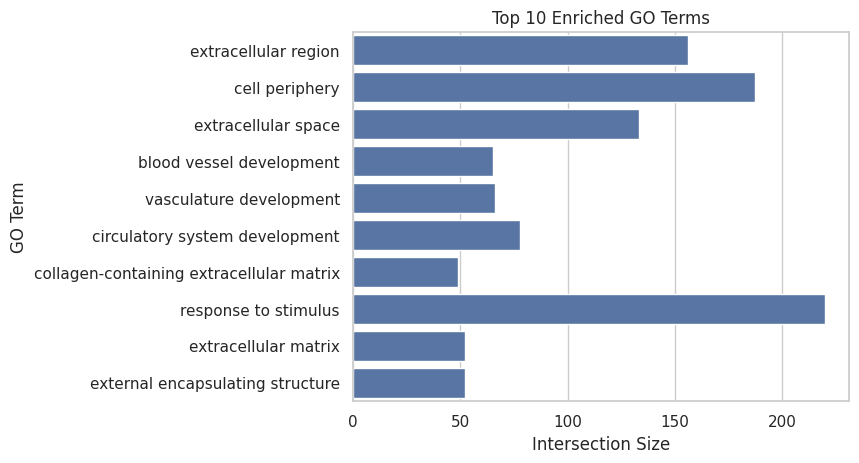

In [74]:
sns.barplot(x='intersection_size', y='name', data=go_results.head(10))
plt.title('Top 10 Enriched GO Terms')
plt.xlabel('Intersection Size')
plt.ylabel('GO Term')
plt.show()

# Pathway analysis

In [16]:
# perform pathway analysis
pathway_analysis_results = gp.profile( organism='hsapiens',  query=gene_list, sources=["KEGG", "REAC"])

# display the results
print(pathway_analysis_results.head())

  source              native                                name  \
0   REAC  REAC:R-HSA-1474244   Extracellular matrix organization   
1   REAC   REAC:R-HSA-216083  Integrin cell surface interactions   
2   KEGG          KEGG:04510                      Focal adhesion   
3   REAC  REAC:R-HSA-3000178                   ECM proteoglycans   
4   KEGG          KEGG:04512            ECM-receptor interaction   

        p_value  significant                         description  term_size  \
0  2.890757e-13         True   Extracellular matrix organization        297   
1  2.639154e-10         True  Integrin cell surface interactions         84   
2  4.099802e-10         True                      Focal adhesion        202   
3  5.470893e-10         True                   ECM proteoglycans         75   
4  1.028177e-08         True            ECM-receptor interaction         89   

   query_size  intersection_size  effective_domain_size  precision    recall  \
0         217                 33    

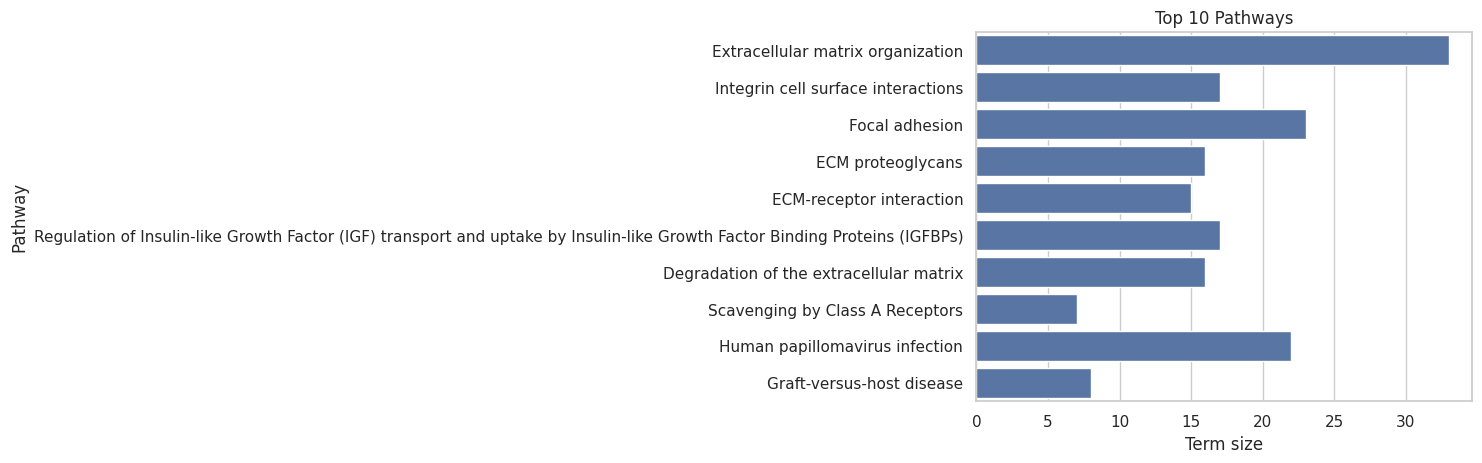

In [15]:
sns.barplot(x='intersection_size', y='name', data=pathway_analysis_results.head(10))
plt.title('Top 10 Pathways')
plt.xlabel('Term size')
plt.ylabel('Pathway')
plt.show()

# GSEA

In [22]:
# create the rank file
rank_df = pd.DataFrame({'Gene': skeletal_muscle['names'], 'Score': skeletal_muscle['scores']})
rank_df.set_index('Gene', inplace=True)

# perform GSEA and view results
gsea_results = gp.prerank(rnk=rank_df, gene_sets='KEGG_2016', permutation_num=100, seed=5)
print(gsea_results.res2d)


2024-08-09 19:32:18,050 [WARNING] Duplicated values found in preranked stats: 18.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


       Name                                               Term        ES  \
0   prerank           Metabolic pathways Homo sapiens hsa01100  0.839477   
1   prerank           Pathways in cancer Homo sapiens hsa05200  0.874995   
2   prerank       Rap1 signaling pathway Homo sapiens hsa04015   0.89219   
3   prerank   PI3K-Akt signaling pathway Homo sapiens hsa04151   0.90091   
4   prerank                  Influenza A Homo sapiens hsa05164  0.878499   
..      ...                                                ...       ...   
95  prerank       ErbB signaling pathway Homo sapiens hsa04012  0.830899   
96  prerank  Fc epsilon RI signaling pathway Homo sapiens h...  0.860172   
97  prerank                     Lysosome Homo sapiens hsa04142  0.858816   
98  prerank   Glucagon signaling pathway Homo sapiens hsa04922   0.80777   
99  prerank  Protein processing in endoplasmic reticulum Ho...  0.825224   

         NES NOM p-val FDR q-val FWER p-val   Tag %  Gene %  \
0    2.24615       0.0  